In [23]:
import pandas as pd
import numpy as np
import joblib
import seaborn as sns

In [2]:
file_name = './df_DkSc_results_COCRYS_DEKOIS_DUD.pkl'
X_merged_dksc = pd.read_pickle(file_name)
# Extract activity column
y_true_merged = X_merged_dksc['activity']
# Drop column from merged_dkksc
X_merged_dksc = X_merged_dksc.drop('activity', axis=1)
X_merged_dksc.shape

(6233, 136)

In [3]:
# RFE Evaluation

In [4]:
!ls ml_models/

conf_selection
RFECV_selector_LogReg_MERGED_random_split.joblib
RFECV_selector_LogReg_MERGED_scaffold_split.joblib
RFECV_selector_RandomForest_MERGED_random_split.joblib
RFECV_selector_RandomForest_MERGED_scaffold_split.joblib


In [5]:
# Funtion to get the dataframe with selected k conformations using RFE
def selected_confs_from_RFE(rfe_selector, X):
    '''Returns a Data Frame with n rows (n = num of protein conformations) and one
       column where each cell contains a list of k indices indicating the selected conformations.
       Selected conformatios are obtained from an rfe_selector estimator and the X matrix.'''
    # Get the features ranking
    df_ranks = pd.DataFrame({'pdb_id': X.columns, 'rfe_ranking': rfe_selector.ranking_})
    # Sort features by ranking
    df_ranks.sort_values('rfe_ranking', inplace = True)
    # Get the dataframe with the list of conf indices per k conformations
    confs_per_k = [ df_ranks.index[:i + 1].tolist() for i in range(len(df_ranks))]
    df_sel_confs = pd.DataFrame({'confs_idx_per_k': confs_per_k})
    return df_sel_confs

In [6]:
X = X_merged_dksc
y = y_true_merged

In [7]:
# Open RFE_estimator
dataset = 'MERGED'
model_name = 'LogReg'
split = 'random'
filename = f'./ml_models/RFECV_selector_{model_name}_{dataset}_{split}_split.joblib'
# RFE selector LogReg Random split
rfe_selector_LR_rd = joblib.load(filename)

#**************************
# Get the features ranking
df_sel_confs_RFE_LR_rd = selected_confs_from_RFE(rfe_selector_LR_rd, X)

In [8]:
# Open RFE_estimator
dataset = 'MERGED'
model_name = 'RandomForest'
split = 'random'
filename = f'./ml_models/RFECV_selector_{model_name}_{dataset}_{split}_split.joblib'
# RFE selector LogReg Random split
rfe_selector_RF_rd = joblib.load(filename)

#**************************
# Get the features ranking
df_sel_confs_RFE_RF_rd = selected_confs_from_RFE(rfe_selector_RF_rd, X)

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score

In [13]:
# Entradas:

In [12]:
import os
import sys
import pickle
sys.path.append('..')
from modules.run_or_load_decorator import run_or_load

In [15]:
#*************************************************
# Functions to compute stratify scaffold splitting
#*************************************************
from scaffold_splitter import train_test_scaffold_split

# Compute or load the dataframe containing the Generic Murcko Scaffolds
file = './df_COCRYS_DUD_DEKOIS_Murcko_Scaffolds_SMILES.obj'

df_scff_murcko = pd.read_pickle(file)

In [31]:
# ********************
def conf_picking_ML(estimator, X_train, X_test, y_train, y_test, df_preselected_confs):
    roc_auc_values = []
    for k in df_preselected_confs['confs_idx_per_k']:
        # 1) Substract X_train and X_test
        X_train_sub = X_train.iloc[:, k]
        X_test_sub = X_test.iloc[:, k]

        # 2) Entrenamiento del modelo
        pipe = Pipeline([('scaler', StandardScaler()), ('estimator', estimator)])
        pipe.fit(X_train_sub, y_train)

        # 3) Prediction
        y_pred_proba = pipe.predict_proba(X_test_sub)[:, 1]

        # 4) Evaluation
        roc_auc = roc_auc_score(y_test, y_pred_proba)

        # 5) Append the ROC-AUC to the list
        roc_auc_values.append(roc_auc)
        
    return(roc_auc_values)

@run_or_load
def randsel_ML(filename, estimator, X, y, 
                       split_type='randSplit', scaffold_series=None,
                       test_size=0.25, nreps=10, verbose=False):
    n_confs = X.shape[1]
    dic_roc_auc_reps = {}
    
    if split_type == 'scffSplit' and scaffold_series is not None:
        #** If scaffold splitting: just do once!
        X_train, X_test, y_train, y_test = \
            train_test_scaffold_split(X, y, 
            scaffold_series=scaffold_series, test_size=test_size, stratify=y)
    
    for rep in range(nreps):
        # ***** Select conformations randomly 
        confs_per_k = [np.random.choice(a = range(n_confs), size=k, replace = False) 
                       for k in range(1, n_confs + 1)]
        df_preselected_confs = pd.DataFrame({'confs_idx_per_k': confs_per_k})
        # ***** 
        roc_auc_values = []
        #** If random split: Randomly split on each rep
        if split_type == 'randSplit':
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y)
            
        roc_auc_values = conf_picking_ML(estimator, X_train, X_test, y_train, y_test, df_preselected_confs)
        dic_roc_auc_reps[f'rep_{rep}'] = roc_auc_values
        
        if verbose:
            print(f'rep: {rep}')
            
    df = pd.DataFrame(dic_roc_auc_reps)
    return(df)
        
@run_or_load     
def presel_ML(filename, estimator, X, y, df_preselected_confs, 
                       split_type='randSplit', scaffold_series=None,
                       test_size=0.25, nreps=5, verbose=False):
    dic_roc_auc_reps = {}
    if split_type == 'scffSplit' and scaffold_series is not None:
        #** If scaffold splitting: just do once!
        X_train, X_test, y_train, y_test = \
            train_test_scaffold_split(X, y, 
            scaffold_series=scaffold_series, test_size=test_size, stratify=y)
        #**
        # override nreps
        nreps = 1 # Only for preselected features
   
    for rep in range(nreps): 
        
        roc_auc_values = []
        
        #** If random split: Randomly split on each rep
        if split_type == 'randSplit':
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y)
            
        roc_auc_values = conf_picking_ML(estimator, X_train, X_test, y_train, y_test, df_preselected_confs)
        dic_roc_auc_reps[f'rep_{rep}'] = roc_auc_values
        
        if verbose:
            print(f'rep: {rep}')
            
    df = pd.DataFrame(dic_roc_auc_reps)
    return(df)


In [18]:
### File naming pattern
# {Score type}_{Train}-{Test}_{split type}__{estimator}_{selection method}

In [19]:
TRAIN_DB = 'MergedDB'
TEST_DB = 'MergedDB'
SCORE_TYPE = 'DkSc'
scaffold_series = df_scff_murcko['scff_generic']

FILEPATH = f'./ml_models/conf_selection/{SCORE_TYPE}_{TRAIN_DB}-{TRAIN_DB}'

def format_filename(*args):
    return '_'.join([*args] ) + '.obj'

File loaded: ./ml_models/conf_selection/DkSc_MergedDB-MergedDB_randSplit_LogReg_randSel_nreps15.obj
File loaded: ./ml_models/conf_selection/DkSc_MergedDB-MergedDB_randSplit_LogReg_rfeSel-LR_nreps15.obj
File loaded: ./ml_models/conf_selection/DkSc_MergedDB-MergedDB_randSplit_LogReg_rfeSel-RF_nreps15.obj
File loaded: ./ml_models/conf_selection/DkSc_MergedDB-MergedDB_scffSplit_LogReg_randSel_nreps15.obj
File loaded: ./ml_models/conf_selection/DkSc_MergedDB-MergedDB_scffSplit_LogReg_rfeSel-LR_nreps15.obj
File loaded: ./ml_models/conf_selection/DkSc_MergedDB-MergedDB_scffSplit_LogReg_rfeSel-RF_nreps15.obj
CPU times: user 266 ms, sys: 18.5 ms, total: 284 ms
Wall time: 285 ms


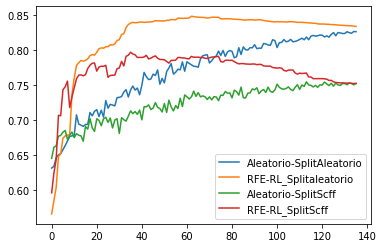

In [36]:
%%time
from sklearn.linear_model import LogisticRegression

estimator_name = 'LogReg'
hyparams = {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear', 'max_iter': 150}
estimator = LogisticRegression(**hyparams)
nreps=15

#*******************
# Splitting: Random
#*******************
split_type = 'randSplit'
#------------------
# Random Selection
#------------------
selection_type = 'randSel'
filename = format_filename(FILEPATH, split_type, estimator_name, selection_type, f'nreps{nreps}') 
randSel_res_rds = randsel_ML(filename, estimator, X, y, nreps=nreps, verbose = True)
#-------------------------
# RFE Selection (Log. Reg selector)
#-------------------------
selection_type = 'rfeSel-LR'
df_preselected_confs = df_sel_confs_RFE_LR_rd
filename = format_filename(FILEPATH, split_type, estimator_name, selection_type, f'nreps{nreps}') 
rfe_LR_res_rds = presel_ML(filename, estimator, X, y, df_preselected_confs, nreps=nreps, verbose=True)
#-------------------------
# RFE Selection (Rand. Forest selector)
#-------------------------
selection_type = 'rfeSel-RF'
df_preselected_confs = df_sel_confs_RFE_RF_rd
filename = format_filename(FILEPATH, split_type, estimator_name, selection_type, f'nreps{nreps}') 
rfe_RF_res_rds = presel_ML(filename, estimator, X, y, df_preselected_confs, nreps=nreps, verbose=True)



#*********************
# Splitting: Scaffold
#*********************
split_type = 'scffSplit'
hyparams = {'C': 100, 'penalty': 'l1', 'solver': 'lbfgs', 'max_iter': 150}
#------------------
# Random Selection
#------------------
selection_type = 'randSel'
filename = format_filename(FILEPATH, split_type, estimator_name, selection_type, f'nreps{nreps}') 
randSel_res_scff = randsel_ML(filename, estimator, X, y, 
                   split_type=split_type, scaffold_series=scaffold_series, nreps=nreps, verbose=True)
#-------------------------
# RFE Selection (Log. Reg selector)
#-------------------------
selection_type = 'rfeSel-LR'
df_preselected_confs = df_sel_confs_RFE_LR_rd
filename = format_filename(FILEPATH, split_type, estimator_name, selection_type, f'nreps{nreps}') 
rfe_LR_res_scff = presel_ML(filename, estimator, X, y, df_preselected_confs, 
                                split_type=split_type, scaffold_series=scaffold_series, verbose=True)
#-------------------------
# RFE Selection (Rand. Forest selector)
#-------------------------
selection_type = 'rfeSel-RF'
df_preselected_confs = df_sel_confs_RFE_RF_rd # Confs selected by RFE with RandForest base estimator
filename = format_filename(FILEPATH, split_type, estimator_name, selection_type, f'nreps{nreps}') 
rfe_RF_res_scff = presel_ML(filename, estimator, X, y, df_preselected_confs, 
                                split_type=split_type, scaffold_series=scaffold_series, verbose=True)


sns.lineplot(range(136), randSel_res_rds.mean(axis=1), label='Aleatorio-SplitAleatorio')
sns.lineplot(range(136), rfe_LR_res_rds.mean(axis=1), label='RFE-RL_Splitaleatorio')
# sns.lineplot(range(136), rfe_RF_res_rds.mean(axis=1), label='RFE-RF_SplitAleatorio')
sns.lineplot(range(136), randSel_res_scff.mean(axis=1), label='Aleatorio-SplitScff')
sns.lineplot(range(136), rfe_LR_res_scff.mean(axis=1), label='RFE-RL_SplitScff')
# sns.lineplot(range(136), rfe_RF_res_scff.mean(axis=1), label='RFE-RF_SplitScff')

File loaded: ./ml_models/conf_selection/DkSc_MergedDB-MergedDB_randSplit_rbfSVC_randSel_nreps15.obj
File loaded: ./ml_models/conf_selection/DkSc_MergedDB-MergedDB_randSplit_rbfSVC_rfeSel-LR_nreps15.obj
File loaded: ./ml_models/conf_selection/DkSc_MergedDB-MergedDB_randSplit_rbfSVC_rfeSel-RF_nreps15.obj
File loaded: ./ml_models/conf_selection/DkSc_MergedDB-MergedDB_scffSplit_rbfSVC_randSel_nreps15.obj
File loaded: ./ml_models/conf_selection/DkSc_MergedDB-MergedDB_scffSplit_rbfSVC_rfeSel-LR_nreps15.obj
File loaded: ./ml_models/conf_selection/DkSc_MergedDB-MergedDB_scffSplit_rbfSVC_rfeSel-RF_nreps15.obj
CPU times: user 206 ms, sys: 8.22 ms, total: 214 ms
Wall time: 292 ms


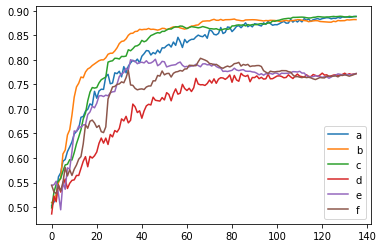

In [34]:
%%time
from sklearn.svm import SVC

estimator_name = 'rbfSVC'
hyparams = {'kernel': 'rbf', 'probability': True, 'C': 10.0, 'gamma': 0.01}
estimator = SVC(**hyparams)
nreps=15

#*******************
# Splitting: Random
#*******************
split_type = 'randSplit'
#------------------
# Random Selection
#------------------
selection_type = 'randSel'
filename = format_filename(FILEPATH, split_type, estimator_name, selection_type, f'nreps{nreps}') 
randSel_res_rds = randsel_ML(filename, estimator, X, y, nreps=nreps, verbose = True)
#-------------------------
# RFE Selection (Log. Reg base estimator)
#-------------------------
selection_type = 'rfeSel-LR'
df_preselected_confs = df_sel_confs_RFE_LR_rd
filename = format_filename(FILEPATH, split_type, estimator_name, selection_type, f'nreps{nreps}') 
rfe_LR_res_rds = presel_ML(filename, estimator, X, y, df_preselected_confs, nreps=nreps, verbose=True)
#-------------------------
# RFE Selection (Rand. Forest base estimator)
#-------------------------
selection_type = 'rfeSel-RF'
df_preselected_confs = df_sel_confs_RFE_RF_rd
filename = format_filename(FILEPATH, split_type, estimator_name, selection_type, f'nreps{nreps}') 
rfe_RF_res_rds = presel_ML(filename, estimator, X, y, df_preselected_confs, nreps=nreps, verbose=True)



#*********************
# Splitting: Scaffold
#*********************
split_type = 'scffSplit'
hyparams = {'C': 100, 'penalty': 'l1', 'solver': 'lbfgs', 'max_iter': 150}
#------------------
# Random Selection
#------------------
selection_type = 'randSel'
filename = format_filename(FILEPATH, split_type, estimator_name, selection_type, f'nreps{nreps}') 
randSel_res_scff = randsel_ML(filename, estimator, X, y, 
                   split_type=split_type, scaffold_series=scaffold_series, nreps=nreps, verbose=True)
#-------------------------
# RFE Selection (Log. Reg base estimator)
#-------------------------
selection_type = 'rfeSel-LR'
df_preselected_confs = df_sel_confs_RFE_LR_rd
filename = format_filename(FILEPATH, split_type, estimator_name, selection_type, f'nreps{nreps}') 
rfe_LR_res_scff = presel_ML(filename, estimator, X, y, df_preselected_confs, 
                                split_type=split_type, scaffold_series=scaffold_series, verbose=True)
#-------------------------
# RFE Selection (Rand. Forest base estimator)
#-------------------------
selection_type = 'rfeSel-RF'
df_preselected_confs = df_sel_confs_RFE_RF_rd # Confs selected by RFE with RandForest base estimator
filename = format_filename(FILEPATH, split_type, estimator_name, selection_type, f'nreps{nreps}') 
rfe_RF_res_scff = presel_ML(filename, estimator, X, y, df_preselected_confs, 
                                split_type=split_type, scaffold_series=scaffold_series, verbose=True)


sns.lineplot(range(136), randSel_res_rds.mean(axis=1), label='a')
sns.lineplot(range(136), rfe_LR_res_rds.mean(axis=1), label='b')
sns.lineplot(range(136), rfe_RF_res_rds.mean(axis=1), label='c')
sns.lineplot(range(136), randSel_res_scff.mean(axis=1), label='d')
sns.lineplot(range(136), rfe_LR_res_scff.mean(axis=1), label='e')
sns.lineplot(range(136), rfe_RF_res_scff.mean(axis=1), label='f')

In [33]:
%%time
from sklearn.ensemble import RandomForestClassifier

estimator_name = 'RandomForest'
hyparams = {'max_depth': 3, 'max_features': 'sqrt', 
            'min_samples_leaf': 0.02, 'min_samples_split': 0.1, 
            'n_estimators': 400}
estimator = RandomForestClassifier(**hyparams)
nreps=15


CPU times: user 61 µs, sys: 6 µs, total: 67 µs
Wall time: 73.4 µs
